### Dataset manipulation using PyTorch

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchsummary import summary
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from PIL import Image 
from torch_snippets import * # Contains functions to manipulate images -- avoids to import cv2, glob, etc.
#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

In [6]:
folder   = './images/corel/'
nclasses = 6 

file_ext   = "*.png"  
model_name = "corel.pth"

### Load dataset filenames and separate them into training, validation, and test sets

In [7]:
train_perc = 0.40
valid_perc = 0.20
test_perc  = 0.40

fileset = Glob(folder+file_ext) # it returns a list of filenames
num_train_samples = int(len(fileset)*train_perc)
num_valid_samples = int(len(fileset)*valid_perc)  
num_test_samples  = len(fileset) - num_train_samples - num_valid_samples 
from random import shuffle, seed; seed(10);
shuffle(fileset)
trainset = fileset[:num_train_samples]
validset = fileset[num_train_samples:num_train_samples+num_valid_samples]
testset  = fileset[num_train_samples+num_valid_samples:]

### Define preprocessing and a class that reads, transforms, and returns images and labels as tuples of tensors

In [8]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0, fillcolor=None, resample=None),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

class DatasetImage(Dataset): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target)    

### Exemplify the execution of DatasetImage 

Number of images: 142
Images are 400x400x3
Class of the image:  1


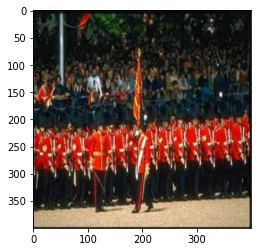

In [9]:
datatensor = DatasetImage(trainset, None)
print("Number of images:", len(datatensor))
image, target = datatensor[50] # it executes getitem
nchannels = image.shape[0]
height    = image.shape[1]
width     = image.shape[2]
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

### Create functions that return random batches from the filename lists in the training, validation, and test sets

In [10]:
batchsize = 32

def GetBatches(dataset, batchsize, transformation):
    datatensor = DatasetImage(dataset, transformation) 
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return(dataloader)

# as transformations, you may choose None, prep, or aug. However, aug applies to the training set only
trainload = GetBatches(trainset, batchsize, prep)  
validload = GetBatches(validset, batchsize, prep)
testload  = GetBatches(testset, batchsize, prep) 

In [11]:
inspect(next(iter(trainload))) # inspect a couple of items in the batches

List Of 2 items
	Tensor	Shape: torch.Size([32, 3, 224, 224])	Min: -2.118	Max: 2.623	Mean: -0.442	dtype: torch.float32
	Tensor	Shape: torch.Size([32])	Min: 0.000	Max: 5.000	Mean: 2.625	dtype: torch.int64


### Create a model using VGG16 pretrained on ImageNet as backbone

In [12]:
def GetModel(nclasses):
    # get the vgg16 model
    model = models.vgg16(pretrained=True)
    # Specify you do not want to train the parameters of the model
    for param in model.parameters():
        param.requires_grad = False
    # The vgg16 model consists of three modules: features, avgpool, and classifier. 
    # Change avgpool to return a feature map of size 1x1 instead of 7x7.This will create
    # batches with 512x1x1 tensors. 
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    # Change the classifier to one suitable for your dataset (e.g., cats-vs-dogs)
    if (nclasses==2): 
        output = 1
        model.classifier = nn.Sequential(nn.Flatten(), \
                                     nn.Linear(512,128), \
                                     nn.ReLU(), \
                                     nn.Dropout(0.2), \
                                     nn.Linear(128, output), \
                                     nn.Sigmoid() )
        loss_fn   = nn.BCELoss()
    else:
        output = nclasses
        model.classifier = nn.Sequential(nn.Flatten(), \
                                     nn.Linear(512,128), \
                                     nn.ReLU(), \
                                     nn.Dropout(0.2), \
                                     nn.Linear(128, output) \
                                    ) # you do not need nn.Softmax() in torch
        loss_fn   = nn.CrossEntropyLoss()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # Return the complete model information for training and evaluation
    return(model.to(device), loss_fn, optimizer)

model, loss_fn, optimizer = GetModel(nclasses)

### Display the model's architecture 

In [13]:
summary(model, (nchannels,height,width))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 12, 12]         --
|    └─Conv2d: 2-1                       [-1, 64, 400, 400]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 400, 400]        --
|    └─Conv2d: 2-3                       [-1, 64, 400, 400]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 400, 400]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 200, 200]        --
|    └─Conv2d: 2-6                       [-1, 128, 200, 200]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 200, 200]       --
|    └─Conv2d: 2-8                       [-1, 128, 200, 200]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 200, 200]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 100, 100]       --
|    └─Conv2d: 2-11                      [-1, 256, 100, 100]       (295,168)
|    └─ReLU: 2-12                        [-1, 256, 100

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 12, 12]         --
|    └─Conv2d: 2-1                       [-1, 64, 400, 400]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 400, 400]        --
|    └─Conv2d: 2-3                       [-1, 64, 400, 400]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 400, 400]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 200, 200]        --
|    └─Conv2d: 2-6                       [-1, 128, 200, 200]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 200, 200]       --
|    └─Conv2d: 2-8                       [-1, 128, 200, 200]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 200, 200]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 100, 100]       --
|    └─Conv2d: 2-11                      [-1, 256, 100, 100]       (295,168)
|    └─ReLU: 2-12                        [-1, 256, 100

### Create a function to train on a batch of data

In [15]:
def TrainBatch(batch, targets, model, optimizer, loss_fn):
    model.train() # put the model in training mode
    prediction = model(batch) # predict the output for the batch
    batch_loss = loss_fn(prediction, targets) # compute loss, both inputs must have the same sizes
    batch_loss.backward() # compute gradients
    optimizer.step() # update parameters
    optimizer.zero_grad() # zeroe gradients for the next batch
    return batch_loss.detach().cpu()

def ValidBatch(batch, targets, model, loss_fn):
    model.eval() # put the model in evaluation mode
    prediction = model(batch) # predict the output for the batch
    batch_loss = loss_fn(prediction, targets) # compute loss, both inputs must have the same sizes
    model.train()
    
    return batch_loss.detach().cpu()


### Train the model by evaluating it on the validation set

EPOCH: 40.000	val_loss: 0.009	(65.01s - 0.00s remaining))

100%|██████████████████████████████████████| 141/141 [00:00<00:00, 20198.67it/s]


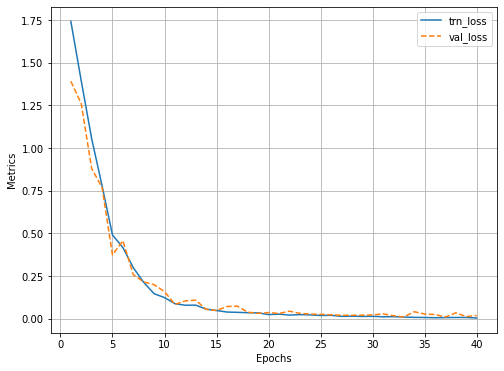

In [16]:
nepochs = 40
log     = Report(nepochs)
for epoch in range(nepochs):
    N = len(trainload)
    for ix, data in enumerate(trainload):
        batch, targets = data
        
        batch   = batch.to(device)
        targets = targets.to(device)
        
        if (nclasses == 2): # put the targets in the correct format for loss computation
            targets        = targets.type(torch.cuda.FloatTensor)
        else: # multiple class)es
            targets        = targets.squeeze()
            
        batch_loss     = TrainBatch(batch, targets, model, optimizer, loss_fn)
        log.record(epoch+(ix+1)/N, trn_loss=batch_loss, end='\r')
    N = len(validload)
    with torch.no_grad():
        for ix, data in enumerate(validload):
            batch, targets = data
        
            batch   = batch.to(device)
            targets = targets.to(device)
        
            if (nclasses == 2): 
                targets        = targets.type(torch.cuda.FloatTensor)
            else:
                targets        = targets.squeeze()
            batch_loss = ValidBatch(batch, targets, model, loss_fn)
            log.record(epoch+(ix+1)/N, val_loss=batch_loss, end='\r')    
log.plot_epochs()       

### Test the trained model

In [12]:
def accuracy(x, y, model, nclasses): 
        prediction = model(x)
        if (nclasses == 2):
            is_correct = (prediction > 0.5) == y
        else:
            y = y.squeeze()
            is_correct = (torch.max(prediction, 1)[1] == y) # verify if the returned indices from torch.max 
                                                            # are the same in y, creating a list with 
                                                            # the boolean results
                  
        return(is_correct.cpu().numpy().tolist())
    
def test(model, test_batches, loss_fn, nclasses):
    #put model in evaluation mode
    model.eval()

    Acc = []
    
    #process all batches
    for ix, data in enumerate(testload):
        batch, targets = data

        batch   = batch.to(device)
        targets = targets.to(device)
        
        #deactivate gradients computation
        with torch.no_grad():

        #do forward through model and return 0/1 for wrong and correct results
             Acc.extend(accuracy(batch, targets, model, nclasses)) # extend current list with the new acc values
    
    return(np.mean(Acc)) 

acc = test(model, testload, loss_fn, nclasses)
print('Acc: {:.6f}'.format(np.mean(acc)))

Acc: 0.992958


### Exercise: Before you move the model to CPU, adapt the same functions used in pytorch-convet.ipynb for visualization of activations and heatmap. You may visualize the output of Vgg-16 and activations from the classifier. 

### Save model

In [13]:
torch.save(model.to('cpu').state_dict(), model_name)
model.to(device) # if you want to execute previous cells

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1